In [2]:
# read paramnames
import numpy as np
from getdist import MCSamples
from pathlib import Path

from pathlib import Path


def overwrite_labels(latex_labels):
    """
    Overwrite certain LaTeX labels if they exist.
    """
    replacements = {
        "H0": r"H_0",
        "sigma8": r"\sigma_8",
        "rd_star": r"r_d^\star",
        "rs_star": r"r_s^\star",
        "fraction_maxion_ac__1": r"f_{\text{ax},1}(a_{c,1})",
        "fraction_maxion_ac__2": r"f_{\text{ax},2}(a_{c,2})",
        "fraction_maxion_ac__3": r"f_{\text{ax},3}(a_{c,3})",
        "fraction_maxion_ac__4": r"f_{\text{ax},4}(a_{c,4})",
        "fraction_maxion_ac__5": r"f_{\text{ax},5}(a_{c,5})",
        "fraction_maxion_ac__6": r"f_{\text{ax},6}(a_{c,6})",
        "fraction_maxion_ac__7": r"f_{\text{ax},7}(a_{c,7})",
        "fraction_maxion_ac__8": r"f_{\text{ax},8}(a_{c,8})",
        "fraction_maxion_ac__9": r"f_{\text{ax},9}(a_{c,9})",
        "log10_maxion_ac__1": r"\log_{10}a_{c,1}",
        "log10_maxion_ac__2": r"\log_{10}a_{c,2}",
        "log10_maxion_ac__3": r"\log_{10}a_{c,3}",
        "log10_maxion_ac__4": r"\log_{10}a_{c,4}",
        "log10_maxion_ac__5": r"\log_{10}a_{c,5}",
        "log10_maxion_ac__6": r"\log_{10}a_{c,6}",
        "log10_maxion_ac__7": r"\log_{10}a_{c,7}",
        "log10_maxion_ac__8": r"\log_{10}a_{c,8}",
        "log10_maxion_ac__9": r"\log_{10}a_{c,9}",
    }

    for key, new_label in replacements.items():
        if key in latex_labels:
            latex_labels[key] = new_label

    return latex_labels



def read_paramnames(directory):
    """
    Find the unique .paramnames file in a directory and return a dict
    mapping parameter names to LaTeX labels.

    Expected format per line:
        <param_name> <whitespace> <latex_label>

    Blank lines and commented lines (#) are ignored.
    """
    directory = Path(directory)

    if not directory.exists():
        raise FileNotFoundError(f"{directory} does not exist")

    if not directory.is_dir():
        raise NotADirectoryError(f"{directory} is not a directory")

    paramfiles = list(directory.glob("*.paramnames"))

    if len(paramfiles) == 0:
        raise FileNotFoundError("No .paramnames file found in directory")
    # if len(paramfiles) > 1:
    #     raise RuntimeError(
    #         f"Expected exactly one .paramnames file, found {len(paramfiles)}: "
    #         + ", ".join(p.name for p in paramfiles)
    #     )

    filename = paramfiles[0]
    labels = {}

    with filename.open("r") as f:
        for line in f:
            line = line.strip()

            # skip empty lines or comments
            if not line or line.startswith("#"):
                continue

            parts = line.split()
            name = parts[0]
            latex = " ".join(parts[1:])

            labels[name] = latex

    return labels



import numpy as np
from pathlib import Path
from getdist import MCSamples

def load_samples(chain_dir, param_names, burnin=0.2):
    """
    Load MCMC samples from a directory containing:
      - exactly one .paramnames file
      - one or more .txt chain files

    Parameters
    ----------
    chain_dir : str or Path
        Directory containing the chains and the .paramnames file.
    param_names : list of str
        Parameters to extract.

    Returns
    -------
    getdist.MCSamples
    """
    chain_dir = Path(chain_dir)

    if not chain_dir.exists():
        raise FileNotFoundError(f"{chain_dir} does not exist")

    if not chain_dir.is_dir():
        raise NotADirectoryError(f"{chain_dir} is not a directory")

    # find chain files: chains are the only .txt files
    chain_files = sorted(chain_dir.glob("*.txt"))
    if not chain_files:
        raise FileNotFoundError("No .txt chain files found")

    # read paramnames from the same directory
    latex_labels = read_paramnames(chain_dir)
    latex_labels = overwrite_labels(latex_labels)  # overwrite certain labels


    # preserve param order from .paramnames
    param_indices = {
        name: i
        for i, name in enumerate(latex_labels.keys())
        if name in param_names
    }

    if not param_indices:
        raise ValueError("None of the requested parameters were found")

    all_weights = []
    all_samples_selected = []

    for chain_file in chain_files:
        try:
            data = np.loadtxt(chain_file)

            if data.ndim != 2 or data.shape[0] < 100:
                continue

            weights = data[:, 0]

            selected_cols = np.column_stack(
                [data[:, idx + 2] for idx in param_indices.values()]
            )

            all_weights.append(weights)
            all_samples_selected.append(selected_cols)

        except Exception:
            continue

    if not all_weights:
        raise RuntimeError("No valid chain files were loaded")

    weights = np.concatenate(all_weights)
    samples = np.concatenate(all_samples_selected)

    samp = MCSamples(
        samples=samples,
        weights=weights,
        names=list(param_indices.keys()),
        labels=[latex_labels[name] for name in param_indices.keys()],
        ignore_rows=burnin,
    )
    samp.setRanges({'fraction_maxion_ac__1':(0.,0.3)})
    samp.setRanges({'fraction_maxion_ac__2':(0.,0.3)})
    samp.setRanges({'fraction_maxion_ac__3':(0.,0.3)})
    samp.setRanges({'fraction_maxion_ac__4':(0.,0.3)})
    samp.setRanges({'fraction_maxion_ac__5':(0.,0.3)})
    samp.setRanges({'fraction_maxion_ac__6':(0.,0.3)})
    samp.setRanges({'fraction_maxion_ac__7':(0.,0.3)})
    samp.setRanges({'fraction_maxion_ac__8':(0.,0.3)})
    samp.setRanges({'fraction_maxion_ac__9':(0.,0.3)})
    return samp

import re

def find_min_loglike(chain_dir,useProcoli=False):
    if useProcoli:
        log_file = next(Path(chain_dir).glob("global_min/*.log"))
    else:
        log_file = next(Path(chain_dir).glob("*.log"))
    pattern = re.compile(r"Minimum of -logLike\s*:\s*([0-9.+-eE]+)")

    for line in log_file.open():
        m = pattern.search(line)
        if m:
            return float(m.group(1))


In [3]:
from pathlib import Path

BASE = Path(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp/"
)

BASE_p = Path(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp/varying_zc"
)
BASE_n = Path(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp/varying_zc_npipe"
)


# =======================
# 0 axions with derived params
# =======================
# chain_0      = BASE / "0_axions/planck_TTTEEElensing2026-01-13"  # nothing
chain_0p     = BASE / "0_axions/planck_TTTEEElensing_pantheon_plus_2026-01-08"
chain_0ps    = BASE / "0_axions/planck_TTTEEElensing_pantheon_plus_sh0es_2026-01-08"
chain_0pd    = BASE / "0_axions/planck_TTTEEElensing_pantheon_plus_desi_2026-01-13"
chain_0psd   = BASE / "0_axions/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2026-01-13"

# =======================
# 1 axion
# =======================
chain_1      = BASE / "1_ax_planck_TTTEEElensing2025-12-23"
chain_1p     = BASE / "1_ax_planck_TTTEEElensing_pantheon_plus2025-12-23"
chain_1ps    = BASE / "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es2025-12-23"
chain_1pd    = BASE / "1_ax_planck_TTTEEElensing_pantheon_plus_desi2025-12-27"
chain_1psd   = BASE / "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es_desi2025-12-23"
chain_1pb    = BASE / "1_ax_planck_TTTEEElensing_pantheon_plus_boss2025-12-23"
chain_1psb   = BASE / "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es_boss2025-12-23"

# =======================
# 4 axions
# # =======================
# chain_4      = BASE / "4_ax_planck_TTTEEElensing2025-11-12"
# chain_4p     = BASE / "4_ax_planck_TTTEEElensing_pantheon_plus2025-11-12"
# chain_4ps    = BASE / "4_ax_planck_TTTEEElensing_pantheon_plus_sh0es2025-11-12"
# # psd doesn't exist for 4 axions
# chain_4pb    = BASE / "4_ax_planck_TTTEEElensing_pantheon_plus_boss2025-11-12"
# chain_4psb   = BASE / "4_ax_planck_TTTEEElensing_pantheon_plus_sh0es_boss2025-11-12"

# =======================
# 9 axions
# =======================
# chain_9      = BASE / "planck_TTTEEElensing_mAxi_shooting2025-11-14"
# chain_9p     = BASE / "planck_TTTEEElensing_pantheon_plus_2025-12-19"
# chain_9ps    = BASE / "planck_TTTEEElensing_pantheon_plus_sh0es_2025-12-19"
# chain_9pd    = BASE / "planck_TTTEEElensing_pantheon_plus_desi_2025-12-19"  
# chain_9psd   = BASE / "planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-19"
# chain_9pb    = BASE / "planck_TTTEEElensing_pantheon_plus_boss_2025-12-19"
# chain_9psb   = BASE / "planck_TTTEEElensing_pantheon_plus_sh0es_boss_2025-12-19"


chain_9      = BASE / "planck_TTTEEElensing_mAxi_shooting2025-11-14"
chain_9p     = BASE / "9_axions_test/planck_TTTEEElensing_pantheon_plus_2025-12-28"
chain_9ps    = BASE / "9_axions_test/planck_TTTEEElensing_pantheon_plus_sh0es_2025-12-23"
chain_9pd    = BASE / "9_axions_test/planck_TTTEEElensing_pantheon_plus_desi_2025-12-27"  
chain_9psd   = BASE / "9_axions_test/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-30"
chain_9pb    = BASE / "9_axions_test/planck_TTTEEElensing_pantheon_plus_boss_2025-12-27"
chain_9psb   = BASE / "9_axions_test/planck_TTTEEElensing_pantheon_plus_sh0es_boss_2025-12-27"

# chain_1pd_p = BASE_p / "1_axion/planck_TTTEEElensing_pantheon_plus_boss_2026-01-30"
# chain_1psd_p = BASE_p / "1_axion/planck_TTTEEElensing_pantheon_plus_sh0es_boss_2026-01-30"
# 1 axion
chain_1pd  = BASE_p / "planck_TTTEEElensing_pantheon_plus_desi_2026-01-14"
chain_1psd = BASE_p / "planck_TTTEEElensing_pantheon_plus_sh0es_desi_2026-01-14"
# 2 axions
chain_2pd  = BASE_p / "2_axions/planck_TTTEEElensing_pantheon_plus_desi_2026-01-19"
chain_2psd = BASE_p  / "2_axions/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2026-01-19"
# 3 axions (latest = 2026-01-16)
chain_3pd_old  = BASE_p  / "3_axions/planck_TTTEEElensing_pantheon_plus_desi_2026-01-19"
chain_3psd_old = BASE_p / "3_axions/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2026-01-19"
# 3 axions (latest = 2026-01-16)
chain_3pd  = BASE_p / "3_axions/v2/planck_TTTEEElensing_pantheon_plus_desi_2026-01-26"
chain_3psd = BASE_p / "3_axions/v2/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2026-01-26"

# 1 axion
chain_1npd  = BASE_n / "1_axion/planck_TTTEEElensing_pantheon_plus_desi_2026-01-30"
chain_1npsd = BASE_n / "1_axion/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2026-01-30"

# 2 axions
chain_2npd  = BASE_n / "2_axions/planck_TTTEEElensing_pantheon_plus_desi_2026-02-02"
chain_2npsd = BASE_n / "2_axions/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2026-02-02"

# 3 axions (latest = 2026-01-16)
chain_3npd  = BASE_n / "3_axions_v2/planck_TTTEEElensing_pantheon_plus_desi_2026-02-02"
chain_3npsd = BASE_n / "3_axions_v2/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2026-02-02"



In [4]:
#param_names = ['fraction_maxion_ac__1', 'fraction_maxion_ac__2', 'fraction_maxion_ac__3', 'log10_maxion_ac__1', 'log10_maxion_ac__2', 'log10_maxion_ac__3']
#param_names = ['fraction_maxion_ac__1', 'log10_maxion_ac__1']
#param_names_4 = ['fraction_maxion_ac__1', 'fraction_maxion_ac__2','fraction_maxion_ac__3', 'fraction_maxion_ac__4', 
#                 'log10_maxion_ac__1', 'log10_maxion_ac__2','log10_maxion_ac__3', 'log10_maxion_ac__4']
param_names =['H0','Omega_m','sigma8','rs_star']

samp_0p = load_samples(
     chain_0p,
     param_names, burnin=0.4
 )

samp_0ps = load_samples(
     chain_0ps,
     param_names
 )

samp_0pd = load_samples(
     chain_0pd,
     param_names
 )
samp_0psd = load_samples(
    chain_0psd,
    param_names
)

Removed 0.4 as burn in
Removed 0.2 as burn in


Removed 0.2 as burn in
Removed 0.2 as burn in


In [17]:
samp_1 = load_samples(
     chain_1,
     param_names, burnin=.4
 )

samp_1p = load_samples(
     chain_1p,
     param_names, burnin=.4
 )

samp_1pd = load_samples(
     chain_1pd,
     param_names
 )

samp_1pb = load_samples(
    chain_1pb,
    param_names
)
samp_1ps = load_samples(
     chain_1ps,
     param_names
 )

samp_1psd = load_samples(
     chain_1psd,
     param_names
 )
samp_1psb = load_samples(
    chain_1psb,
    param_names
)




Removed 0.4 as burn in
Removed 0.4 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in


In [6]:

samp_9p = load_samples(
     chain_9p,
     param_names
 )

samp_9pd = load_samples(
     chain_9pd,
     param_names
 )
samp_9pb = load_samples(
    chain_9pb,
    param_names
)
samp_9ps = load_samples(
     chain_9ps,
     param_names
 )

samp_9psd = load_samples(
     chain_9psd,
     param_names
 )
samp_9psb = load_samples(
    chain_9psb,
    param_names
)

Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in


/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_42431/281234531.py:149: UserWarning: loadtxt: input contained no data: "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp/9_axions_test/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-30/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-30_+H0_time_stamps.txt"
  data = np.loadtxt(chain_file)


Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in


/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_42431/281234531.py:149: UserWarning: loadtxt: input contained no data: "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp/9_axions_test/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-30/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-30_+H0_time_stamps.txt"
  data = np.loadtxt(chain_file)


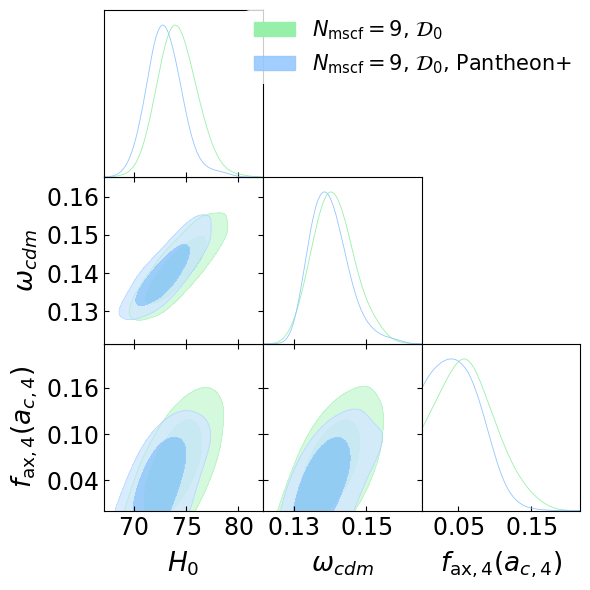

In [7]:
import plotting.plotting as pl
import matplotlib.pyplot as plt

param_names_basic =['H0','omega_cdm','fraction_maxion_ac__4']


samp_9 = load_samples(
     chain_9,
     param_names_basic
 )

samp_9p_basic = load_samples(
    chain_9p,
    param_names_basic
)
samp_9ps_basic = load_samples(
    chain_9ps,
    param_names_basic
)
samp_9psd_basic = load_samples(
    chain_9psd,
    param_names_basic
)




g = pl.my_plotter()


fig = g.triangle_plot(
    [samp_9,samp_9p_basic],
    params=param_names_basic,
    filled=True,
    legend_labels=[
        r"$N_\text{mscf}=9$, $\mathcal{D}_0$",
        r"$N_\text{mscf}=9$, $\mathcal{D}_0$, Pantheon+",
    ]
)

plt.show()

from plotting.plotting import PLOT_DIR
g.export(str(PLOT_DIR / "99p.pdf"))



Removed 0.3 as burn in
Removed 0.3 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in


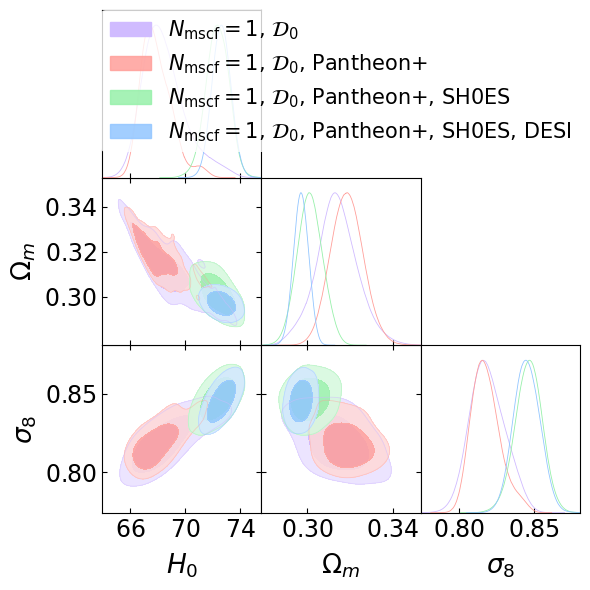

In [8]:
import plotting.plotting as pl
import matplotlib.pyplot as plt

param_names_comparison =['H0','Omega_m','sigma8']
csamp_1 = load_samples(
     chain_1,
     param_names_comparison, burnin=0.3
 )

csamp_1p = load_samples(
     chain_1p,
     param_names_comparison,burnin=0.3
 )

csamp_1ps = load_samples(
     chain_1ps,
     param_names_comparison
 )

csamp_1psd = load_samples(
     chain_1psd,
     param_names_comparison
 )

g = pl.my_plotter()

fig = g.triangle_plot(
    [csamp_1,csamp_1p,csamp_1ps,csamp_1psd],
    params=param_names_comparison,
    filled=True,
    legend_labels=[
        r"$N_\text{mscf}=1$, $\mathcal{D}_0$",
        r"$N_\text{mscf}=1$, $\mathcal{D}_0$, Pantheon+",
        r"$N_\text{mscf}=1$, $\mathcal{D}_0$, Pantheon+, SH0ES",
        r"$N_\text{mscf}=1$, $\mathcal{D}_0$, Pantheon+, SH0ES, DESI",
    ],
)

plt.show()

from plotting.plotting import PLOT_DIR
g.export(str(PLOT_DIR / "11p1ps1psd.pdf"))



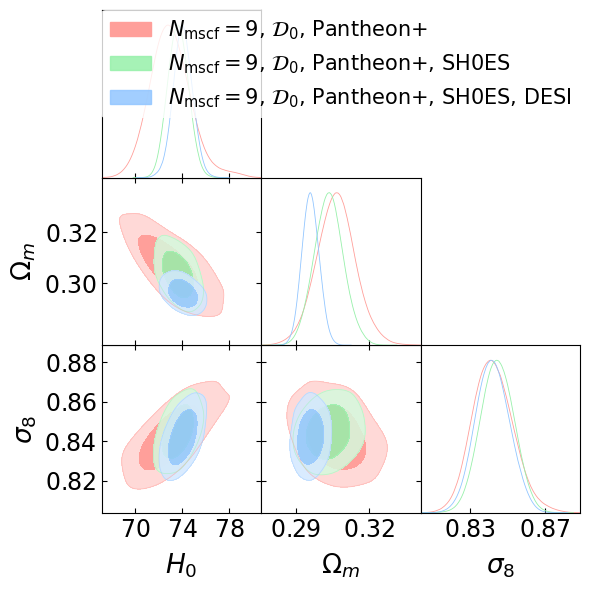

In [9]:
import plotting.plotting as pl
import matplotlib.pyplot as plt


g = pl.my_plotter()

fig = g.triangle_plot(
    [samp_9p,samp_9ps,samp_9psd],
    params=param_names_comparison,
    filled=True,
    legend_labels=[
        r"$N_\text{mscf}=9$, $\mathcal{D}_0$, Pantheon+",
        r"$N_\text{mscf}=9$, $\mathcal{D}_0$, Pantheon+, SH0ES",
        r"$N_\text{mscf}=9$, $\mathcal{D}_0$, Pantheon+, SH0ES, DESI",
    ],
)

plt.show()

from plotting.plotting import PLOT_DIR
g.export(str(PLOT_DIR / "9p9ps9psd.pdf"))



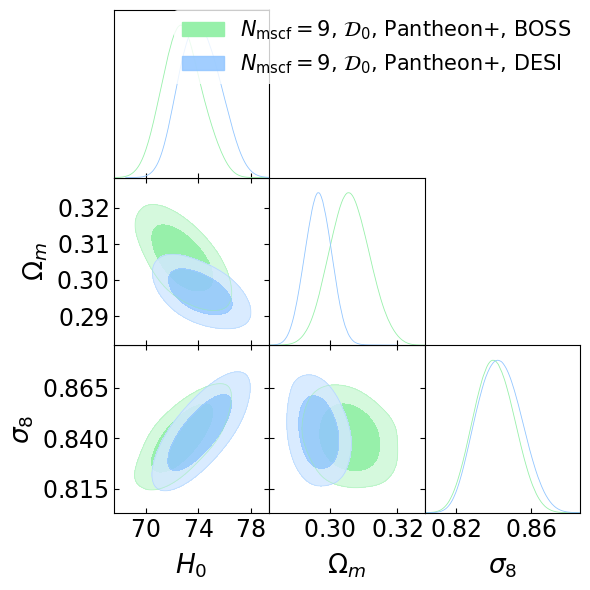

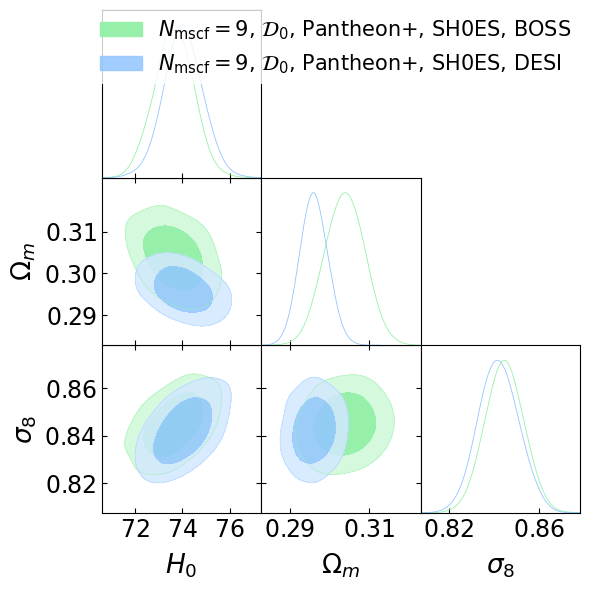

In [10]:
import plotting.plotting as pl
import matplotlib.pyplot as plt


g = pl.my_plotter()

fig = g.triangle_plot(
    [samp_9pb,samp_9pd],
    params=param_names_comparison,
    filled=True,
    legend_labels=[
        r"$N_\text{mscf}=9$, $\mathcal{D}_0$, Pantheon+, BOSS",
        r"$N_\text{mscf}=9$, $\mathcal{D}_0$, Pantheon+, DESI",
    ],
)

plt.show()

from plotting.plotting import PLOT_DIR
g.export(str(PLOT_DIR / "9pb9pd.pdf"))



g = pl.my_plotter()

fig = g.triangle_plot(
    [samp_9psb,samp_9psd],
    params=param_names_comparison,
    filled=True,
    legend_labels=[
        r"$N_\text{mscf}=9$, $\mathcal{D}_0$, Pantheon+, SH0ES, BOSS",
        r"$N_\text{mscf}=9$, $\mathcal{D}_0$, Pantheon+, SH0ES, DESI",
    ],
)

plt.show()

from plotting.plotting import PLOT_DIR
g.export(str(PLOT_DIR / "9psb9psd.pdf"))




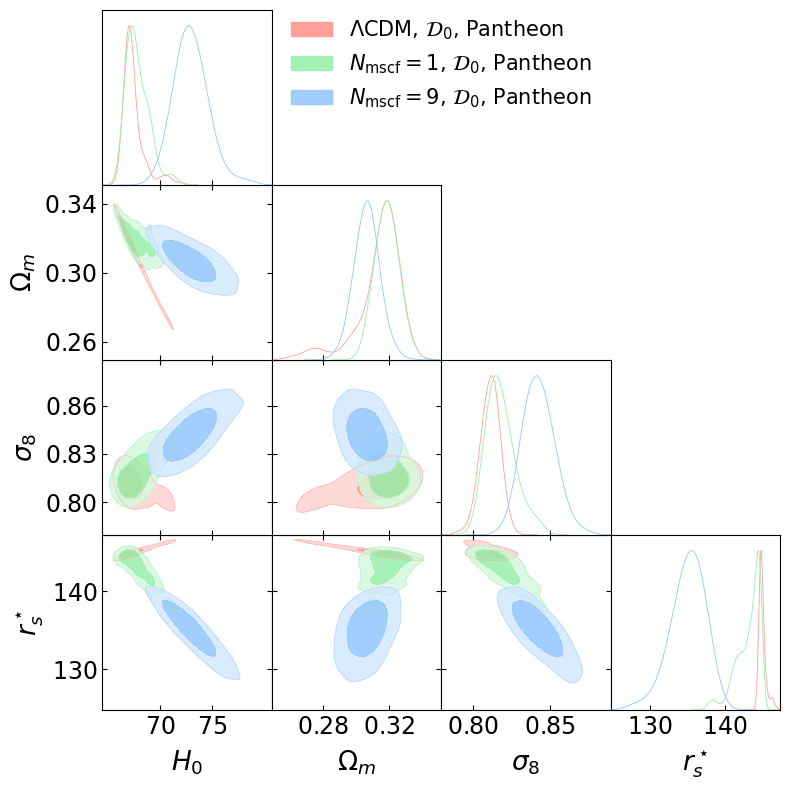

In [11]:
import plotting.plotting as pl
import matplotlib.pyplot as plt

g = pl.my_plotter()


fig = g.triangle_plot(
    [samp_0p,samp_1p, samp_9p],
    params=param_names,
    filled=True,
    legend_labels=[
        r"$\Lambda$CDM, $\mathcal{D}_0$, Pantheon",
        r"$N_\text{mscf}=1$, $\mathcal{D}_0$, Pantheon",
        r"$N_\text{mscf}=9$, $\mathcal{D}_0$, Pantheon",
    ]
)

plt.show()

from plotting.plotting import PLOT_DIR
g.export(str(PLOT_DIR / "0p1p9p.pdf"))



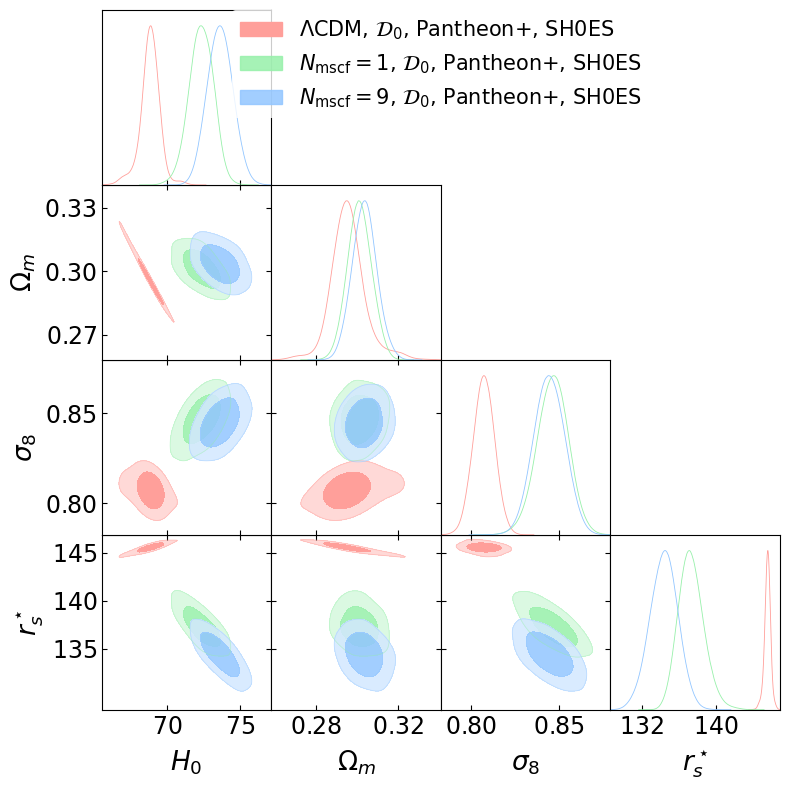

In [12]:
import plotting.plotting as pl
import matplotlib.pyplot as plt

g = pl.my_plotter()


fig = g.triangle_plot(
    [samp_0ps,samp_1ps, samp_9ps],
    params=param_names,
    filled=True,
    legend_labels=[
        r"$\Lambda$CDM, $\mathcal{D}_0$, Pantheon+, SH0ES",
        r"$N_\text{mscf}=1$, $\mathcal{D}_0$, Pantheon+, SH0ES",
        r"$N_\text{mscf}=9$, $\mathcal{D}_0$, Pantheon+, SH0ES",
    ]
)

plt.show()

from plotting.plotting import PLOT_DIR
g.export(str(PLOT_DIR / "0ps1ps9ps.pdf"))



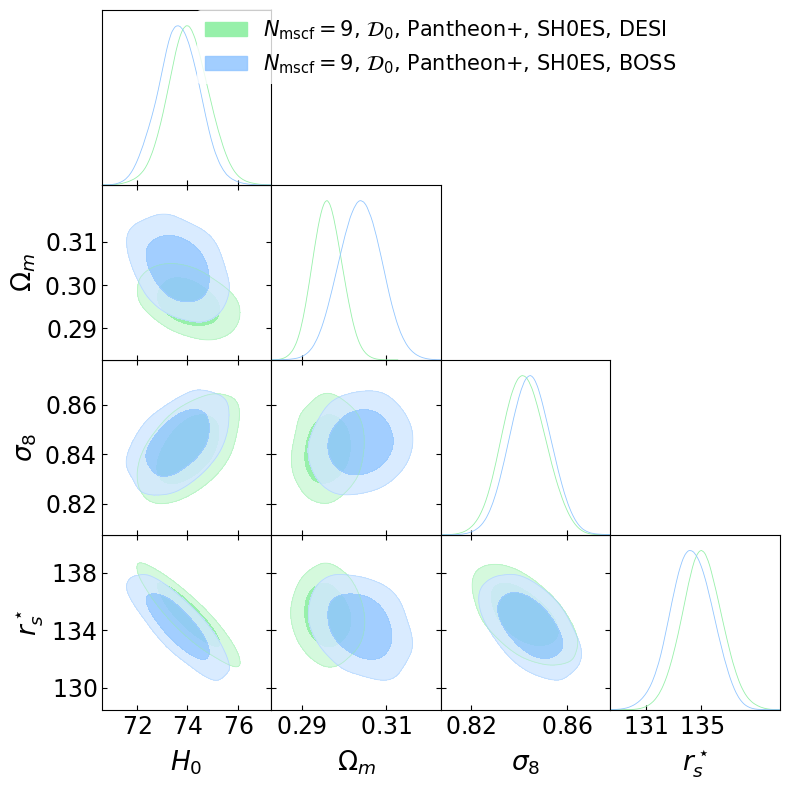

In [13]:
import plotting.plotting as pl
import matplotlib.pyplot as plt

g = pl.my_plotter()


fig = g.triangle_plot(
    [samp_9psd, samp_9psb],
    params=param_names,
    filled=True,
    legend_labels=[
        r"$N_\text{mscf}=9$, $\mathcal{D}_0$, Pantheon+, SH0ES, DESI",
        r"$N_\text{mscf}=9$, $\mathcal{D}_0$, Pantheon+, SH0ES, BOSS",
    ]
)

plt.show()

from plotting.plotting import PLOT_DIR
g.export(str(PLOT_DIR / "9psd9psb.pdf"))



Removed 0.2 as burn in
Removed 0.2 as burn in


/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_42431/281234531.py:149: UserWarning: loadtxt: input contained no data: "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp/9_axions_test/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-30/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-30_+H0_time_stamps.txt"
  data = np.loadtxt(chain_file)


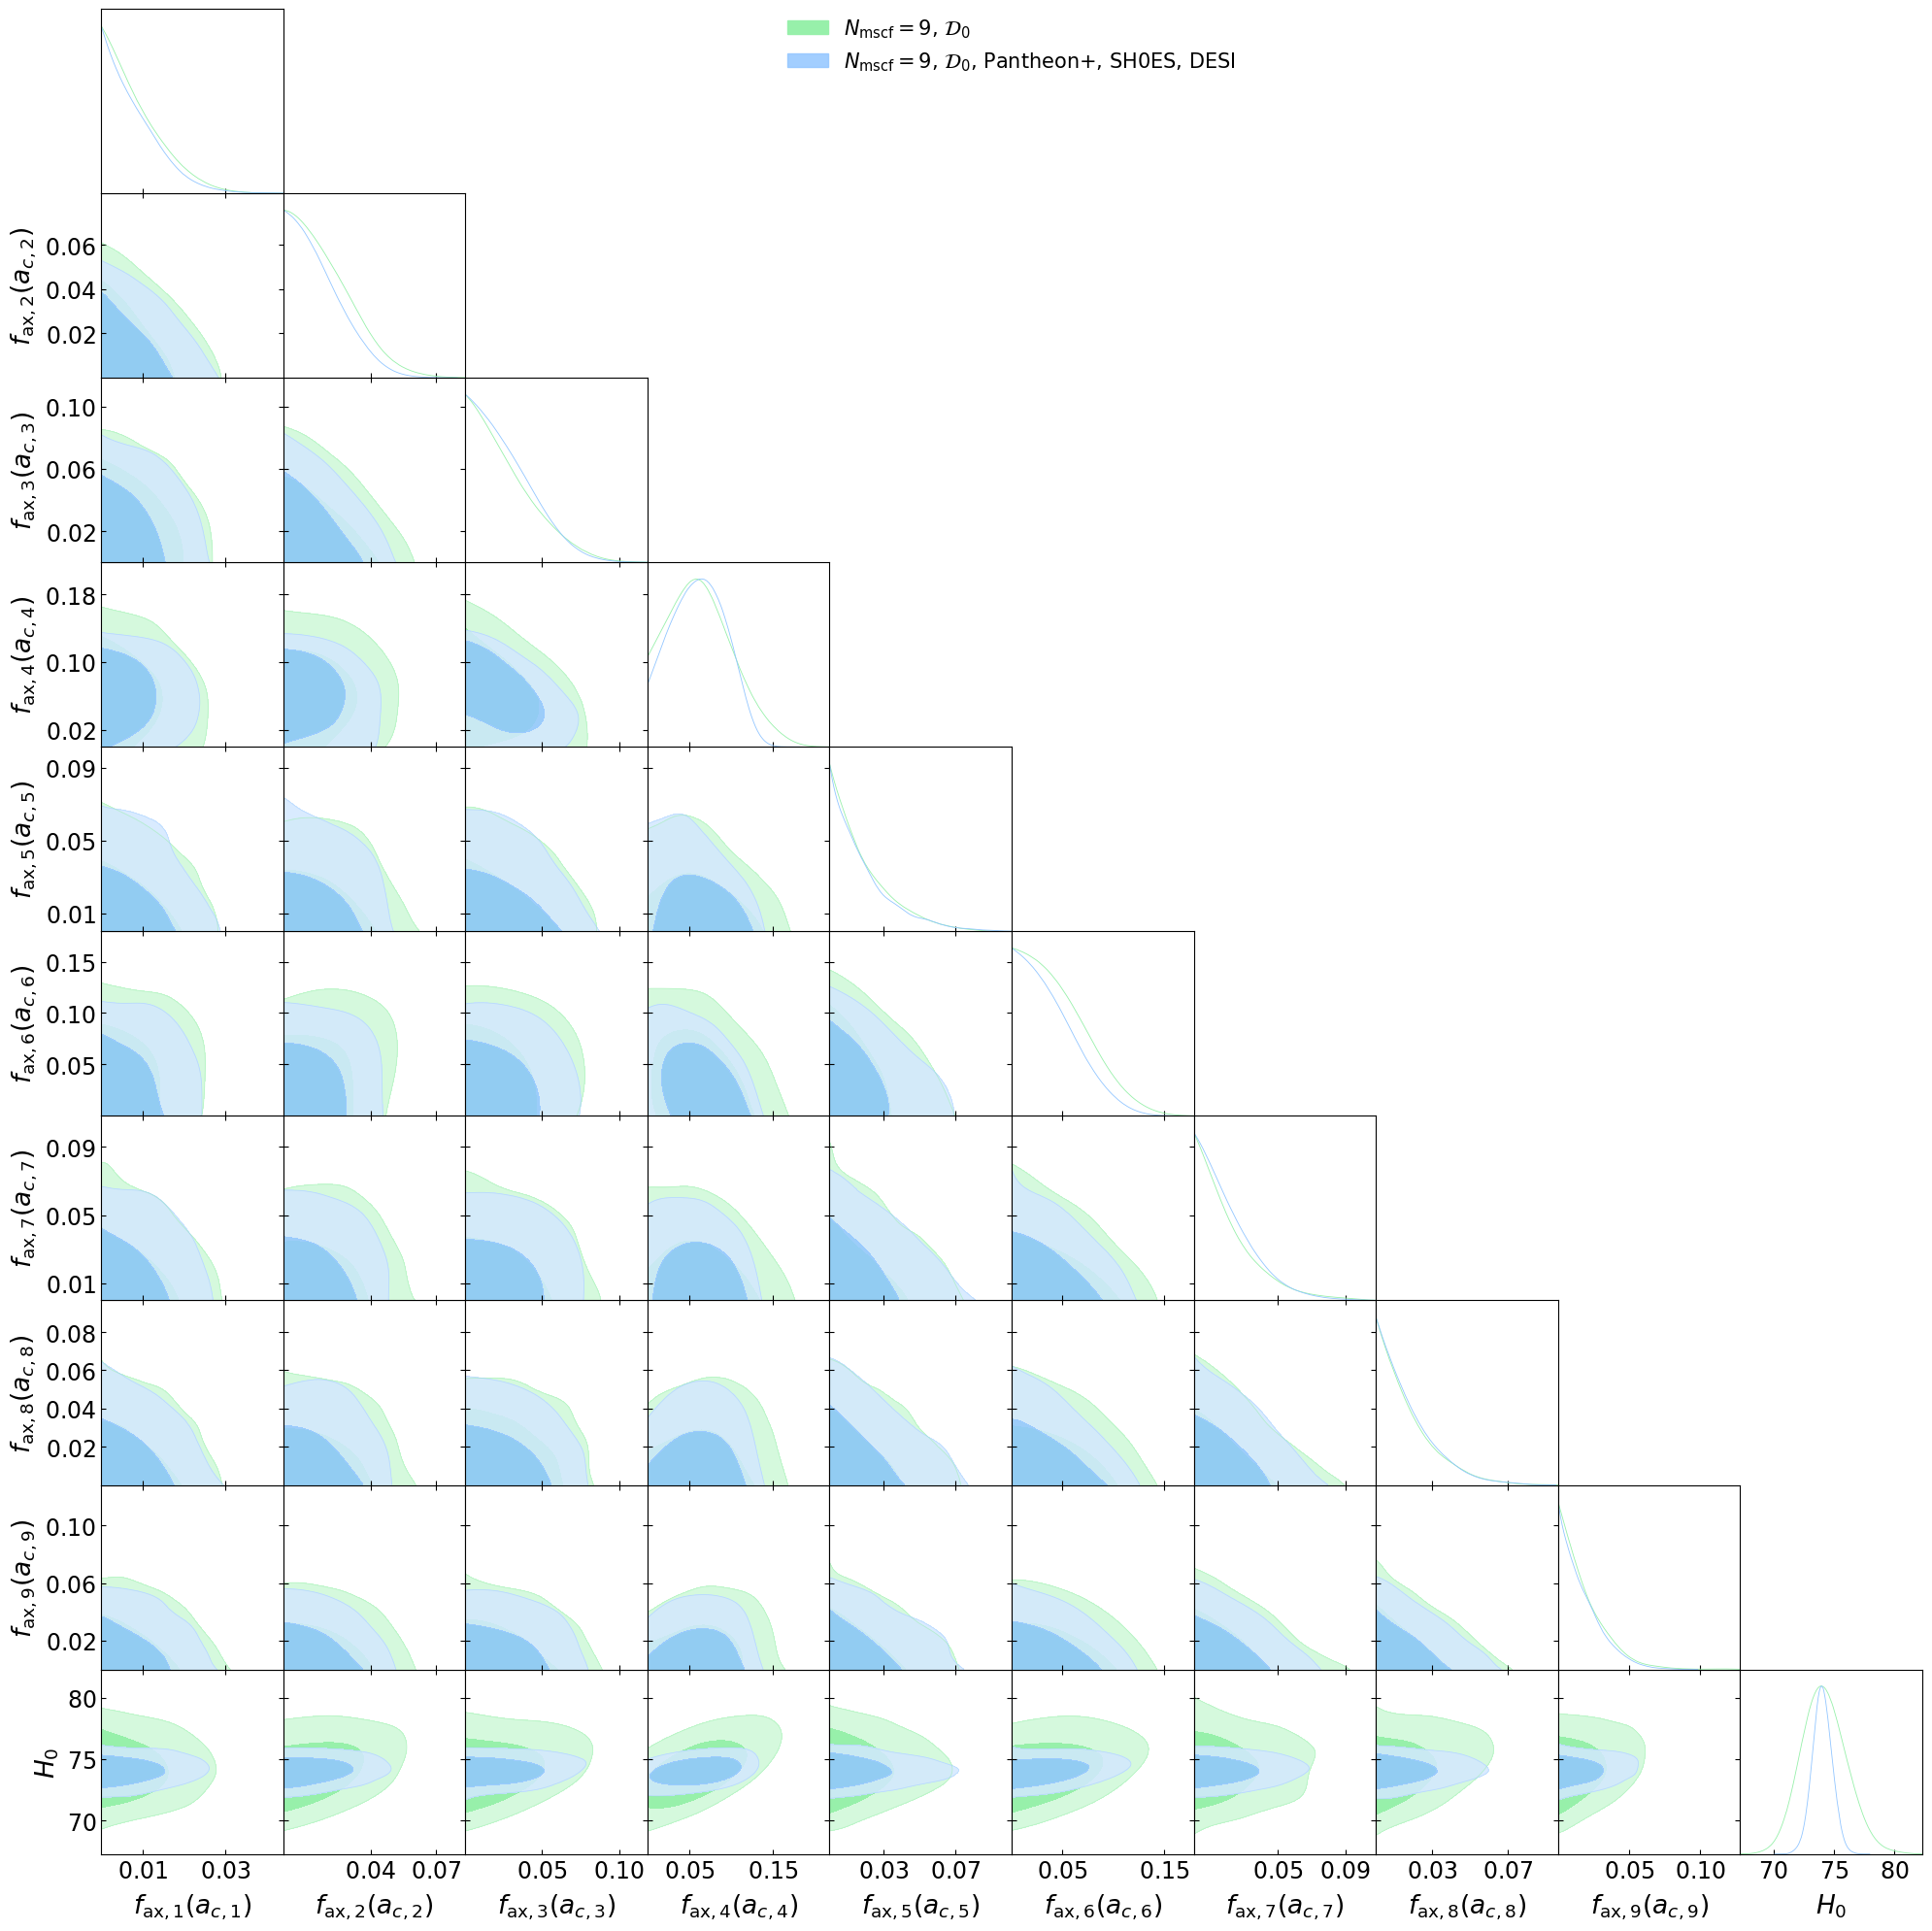

In [14]:
param_names_axion =['fraction_maxion_ac__1','fraction_maxion_ac__2','fraction_maxion_ac__3',
                    'fraction_maxion_ac__4','fraction_maxion_ac__5','fraction_maxion_ac__6',
                    'fraction_maxion_ac__7','fraction_maxion_ac__8','fraction_maxion_ac__9', 'H0'
                   ]


samp_9_axion = load_samples(
     chain_9,
     param_names_axion
 )


samp_9psd_axion = load_samples(
     chain_9psd,
     param_names_axion
 )


import plotting.plotting as pl
import matplotlib.pyplot as plt

g = pl.my_plotter()


fig = g.triangle_plot(
    [samp_9_axion,samp_9psd_axion],
    params=param_names_axion,
    filled=True,
    legend_labels=[
        r"$N_\text{mscf}=9$, $\mathcal{D}_\text{0}$",
        r"$N_\text{mscf}=9$, $\mathcal{D}_\text{0}$, Pantheon+, SH0ES, DESI",
    ]
)

plt.show()

from plotting.plotting import PLOT_DIR
g.export(str(PLOT_DIR / "99psd.pdf"))



In [15]:
# Get the marginalized statistics for each set of samples
stats_9 = samp_9_axion.getMargeStats()
stats_9psd = samp_9psd_axion.getMargeStats()

# Print the table in console
print("Marginalized constraints (68% limits):")
print("-" * 80)
print(f"{'Parameter':<30} {'N_mscf=9, D0':<30} {'N_mscf=9, D0, Pantheon+, SH0ES, DESI':<40}")
print("-" * 80)

for param in param_names_axion:
    # Get parameter info for both samples
    par1 = stats_9.parWithName(param)
    par2 = stats_9psd.parWithName(param)
    
    # Get mean ± std or asymmetric limits
    if par1 and par2:
        # Format with mean ± error (or asymmetric limits)
        mean1, err1 = par1.mean, par1.err
        mean2, err2 = par2.mean, par2.err
        
        # Check if we have symmetric limits
        if hasattr(par1, 'limits') and len(par1.limits) > 0:
            lim1 = par1.limits[0]  # First limit (68% by default)
            lim2 = par2.limits[0]
            
            if lim1.twotail:  # Two-tail symmetric limits
                val1 = f"{mean1:.3f} ± {err1:.3f}"
                val2 = f"{mean2:.3f} ± {err2:.3f}"
            else:  # One-tail or asymmetric limits
                val1 = f"{mean1:.3f} +{lim1.upper-mean1:.3f} -{mean1-lim1.lower:.3f}"
                val2 = f"{mean2:.3f} +{lim2.upper-mean2:.3f} -{mean2-lim2.lower:.3f}"
        else:
            val1 = f"{mean1:.3f} ± {err1:.3f}"
            val2 = f"{mean2:.3f} ± {err2:.3f}"
        
        print(f"{param:<30} {val1:<30} {val2:<40}")

print("-" * 80)

# Alternative: Get LaTeX table
print("\nLaTeX table snippet:")
print("-" * 80)
for param in param_names_axion:
    latex1 = samp_9_axion.getInlineLatex(param, limit=1)  # 68% limit
    latex2 = samp_9psd_axion.getInlineLatex(param, limit=1)
    print(f"{param} & {latex1} & {latex2} \\\\")

# Or create a proper ResultTable for publication
from getdist.types import ResultTable

print("\n\nFormatted ResultTable (LaTeX):")
print("-" * 80)
table = ResultTable(
    ncol=1,  # One column per result set
    results=[samp_9_axion, samp_9psd_axion],
    paramList=param_names_axion,
    limit=1,  # First limit (68% by default)
    titles=[
        r"$N_\text{mscf}=9$, $\mathcal{D}_\text{0}$",
        r"$N_\text{mscf}=9$, $\mathcal{D}_\text{0}$, Pantheon+, SH0ES, DESI"
    ]
)

print(table.tableTex())

# Save to file
with open("parameter_constraints.tex", "w") as f:
    f.write(table.tableTex())

Marginalized constraints (68% limits):
--------------------------------------------------------------------------------
Parameter                      N_mscf=9, D0                   N_mscf=9, D0, Pantheon+, SH0ES, DESI    
--------------------------------------------------------------------------------
fraction_maxion_ac__1          0.008 +0.002 -0.008            0.008 +0.002 -0.008                     
fraction_maxion_ac__2          0.019 +0.005 -0.019            0.016 +0.004 -0.016                     
fraction_maxion_ac__3          0.026 +0.006 -0.026            0.027 +0.007 -0.027                     
fraction_maxion_ac__4          0.065 ± 0.038                  0.062 ± 0.032                           
fraction_maxion_ac__5          0.019 +0.004 -0.019            0.019 +0.003 -0.019                     
fraction_maxion_ac__6          0.046 +0.013 -0.046            0.039 +0.011 -0.039                     
fraction_maxion_ac__7          0.021 +0.004 -0.021            0.020 +0.005 -0.

In [16]:
# Get the marginalized statistics for each set of samples
param_names_axion =['H0','Omega_m','sigma8','rs_star','fraction_maxion_ac__1','log10_maxion_ac__1']
samp_1psd = load_samples(
     chain_1psd,
     param_names_axion
 )

samp_1 = load_samples(
     chain_1,
     param_names_axion
 )
stats_9 = samp_1.getMargeStats()
stats_9psd = samp_1psd.getMargeStats()

# Print the table in console
print("Marginalized constraints (68% limits):")
print("-" * 80)
print(f"{'Parameter':<30} {'N_mscf=9, D0':<30} {'N_mscf=9, D0, Pantheon+, SH0ES, DESI':<40}")
print("-" * 80)

for param in param_names_axion:
    # Get parameter info for both samples
    par1 = stats_9.parWithName(param)
    par2 = stats_9psd.parWithName(param)
    
    # Get mean ± std or asymmetric limits
    if par1 and par2:
        # Format with mean ± error (or asymmetric limits)
        mean1, err1 = par1.mean, par1.err
        mean2, err2 = par2.mean, par2.err
        
        # Check if we have symmetric limits
        if hasattr(par1, 'limits') and len(par1.limits) > 0:
            lim1 = par1.limits[0]  # First limit (68% by default)
            lim2 = par2.limits[0]
            
            if lim1.twotail:  # Two-tail symmetric limits
                val1 = f"{mean1:.3f} ± {err1:.3f}"
                val2 = f"{mean2:.3f} ± {err2:.3f}"
            else:  # One-tail or asymmetric limits
                val1 = f"{mean1:.3f} +{lim1.upper-mean1:.3f} -{mean1-lim1.lower:.3f}"
                val2 = f"{mean2:.3f} +{lim2.upper-mean2:.3f} -{mean2-lim2.lower:.3f}"
        else:
            val1 = f"{mean1:.3f} ± {err1:.3f}"
            val2 = f"{mean2:.3f} ± {err2:.3f}"
        
        print(f"{param:<30} {val1:<30} {val2:<40}")

print("-" * 80)

# Alternative: Get LaTeX table
print("\nLaTeX table snippet:")
print("-" * 80)
for param in param_names_axion:
    latex1 = samp_9_axion.getInlineLatex(param, limit=1)  # 68% limit
    latex2 = samp_9psd_axion.getInlineLatex(param, limit=1)
    print(f"{param} & {latex1} & {latex2} \\\\")

# Or create a proper ResultTable for publication
from getdist.types import ResultTable

print("\n\nFormatted ResultTable (LaTeX):")
print("-" * 80)
table = ResultTable(
    ncol=1,  # One column per result set
    results=[samp_9_axion, samp_9psd_axion],
    paramList=param_names_axion,
    limit=1,  # First limit (68% by default)
    titles=[
        r"$N_\text{mscf}=9$, $\mathcal{D}_\text{0}$",
        r"$N_\text{mscf}=9$, $\mathcal{D}_\text{0}$, Pantheon+, SH0ES, DESI"
    ]
)

print(table.tableTex())

# Save to file
with open("parameter_constraints.tex", "w") as f:
    f.write(table.tableTex())

Removed 0.2 as burn in
Removed 0.2 as burn in
Marginalized constraints (68% limits):
--------------------------------------------------------------------------------
Parameter                      N_mscf=9, D0                   N_mscf=9, D0, Pantheon+, SH0ES, DESI    
--------------------------------------------------------------------------------
H0                             68.463 ± 1.590                 72.649 ± 0.686                          
Omega_m                        0.314 ± 0.010                  0.297 ± 0.003                           
sigma8                         0.819 ± 0.012                  0.845 ± 0.009                           
rs_star                        142.839 ± 2.052                137.545 ± 1.281                         
fraction_maxion_ac__1          0.042 +0.009 -0.042            0.136 +0.020 -0.020                     
log10_maxion_ac__1             -3.418 ± 0.843                 -3.571 ± 0.031                          
--------------------------------

ValueError: parameter Omega_m not found

In [83]:
def find_min_loglike(chain_dir,useProcoli=False):
    if useProcoli:
        log_file = next(Path(chain_dir).glob("global_min/*.log"))
    else:
        log_file = next(Path(chain_dir).glob("*.log"))
    pattern = re.compile(r"Minimum of -logLike\s*:\s*([0-9.+-eE]+)")

    for line in log_file.open():
        m = pattern.search(line)
        if m:
            return float(m.group(1))



In [20]:
min_loglike_pd = []
# min_loglike_pd_procoli = []
min_loglike_psd = []
# min_loglike_psd_procoli = []
# chains_pd = [chain_0pd,chain_1pd,chain_9pd]
# chai1s_psd = [chain_0psd,chain_1psd,chain_9psd]
chain_1pd = BASE / "1_ax_planck_TTTEEElensing_pantheon_plus_desi2025-12-27"
chain_1psd = BASE / "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es_desi2025-12-23"

chains_pd = [chain_1pd,chain_9pd]
chains_psd = [chain_1psd,chain_9psd]
for i in range(2):
    chain_pd = param_names_axion[i]
    chain_psd = chains_psd[i]
    min_loglike_pd.append(find_min_loglike(chain_pd, useProcoli=True))
    min_loglike_psd.append(find_min_loglike(chain_psd,useProcoli=True))
    ####no procoli for 4psd yet###
    # try:
    #     loglike_pd_procoli.append(find_min_loglike(chain_pd_proc,useProcoli=True))
    #     loglike_psd_procoli.append(find_min_loglike(chain_psd_proc,useProcoli=True))
    # except:
    #     loglike_pd_procoli.append(np.nan)       
    #     loglike_psd_procoli.append(np.nan)       

n_axions = [0,1,9]
# convert to chi^2
chi2_pd  = 2 * np.array(min_loglike_pd)
# chi2_pd_procoli  = 2 * np.array(min_loglike_pd_procoli)
chi2_psd = 2 * np.array(min_loglike_psd)
# chi2_psd_procoli  = 2 * np.array(min_loglike_psd_procoli)
print(chi2_pd)
print(chi2_psd)


plt.figure(figsize=(7, 5))

min=0
max=5

# plt.plot(
#     n_axions[min:max], 
#     chi2_pd_procoli[min:max],
#     color="C0",
#     marker="o",
#     lw=2,
#     # linestyle="--",
#     alpha=0.5,
#     label="Pantheon+ DESI (procoli)"
# )

# plt.plot(
#     n_axions[min:max],
#     chi2_psd_procoli[min:max],
#     color="C1",
#     marker="s",
#     lw=2,
#     # linestyle="--",
#     alpha=0.5,
#     label="Pantheon+ DESI + SH0ES (procoli)"
# )

# plt.xlabel("Number of axions")
# plt.ylabel(r"$\chi^2_{\mathrm{min}}$")
# plt.xticks(n_axions)
# plt.legend()
# plt.grid(alpha=0.3)
# plt.ylim(2434,2445)
# plt.tight_layout()
# plt.title("1,2,3,4 axions, Planck+Pantheon+ with/without sh0es")
# plt.show()


[2435.94 2436.98]
[2315.72 2313.52]


<Figure size 700x500 with 0 Axes>

Removed 0.2 as burn in
Removed 0.2 as burn in


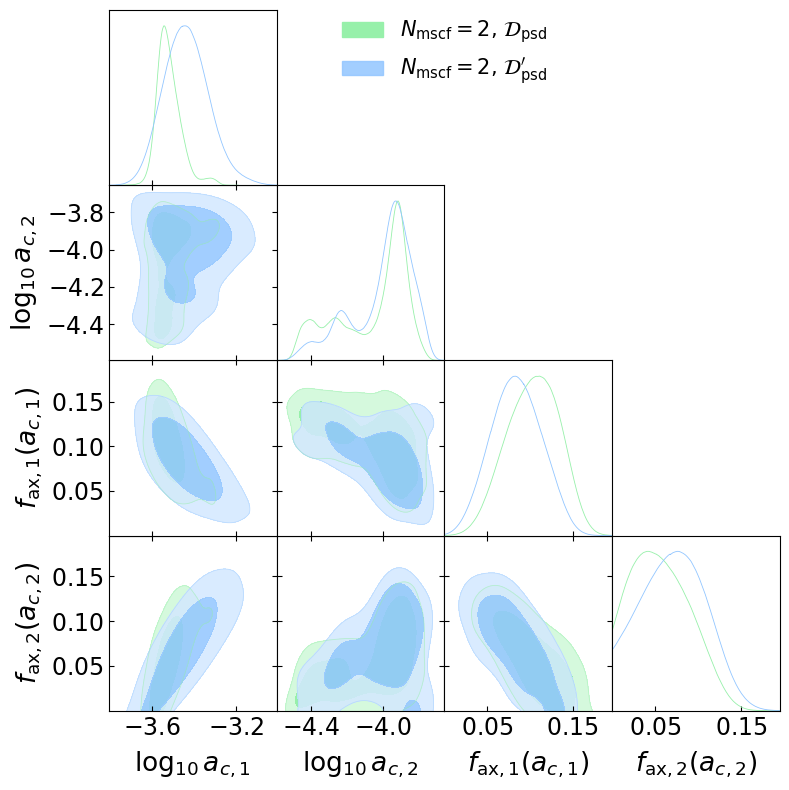

In [18]:
param_names_axion =['log10_maxion_ac__1', 'log10_maxion_ac__2', 'fraction_maxion_ac__1','fraction_maxion_ac__2']



samp_2psd = load_samples(
     chain_2psd,
     param_names_axion, burnin=0.2
 )


samp_2npsd = load_samples(
     chain_2npsd,
     param_names_axion,burnin=0.2
 )


import plotting.plotting as pl
import matplotlib.pyplot as plt

g = pl.my_plotter()


fig = g.triangle_plot(
    [samp_2psd,samp_2npsd],
    params=param_names_axion,
    filled=True,
    legend_labels=[
        r"$N_\text{mscf}=2$, $\mathcal{D}_{\text{psd}}$",
        r"$N_\text{mscf}=2$, $\mathcal{D}^\prime_{\text{psd}}$",
    ]
)

plt.show()

from plotting.plotting import PLOT_DIR
g.export(str(PLOT_DIR / "2psdnpsd.pdf"))



Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Global limits:
H0: [69.602, 76.039]
Omega_m: [0.281, 0.312]
sigma8: [0.797, 0.884]
rs_star: [131.865, 143.438]


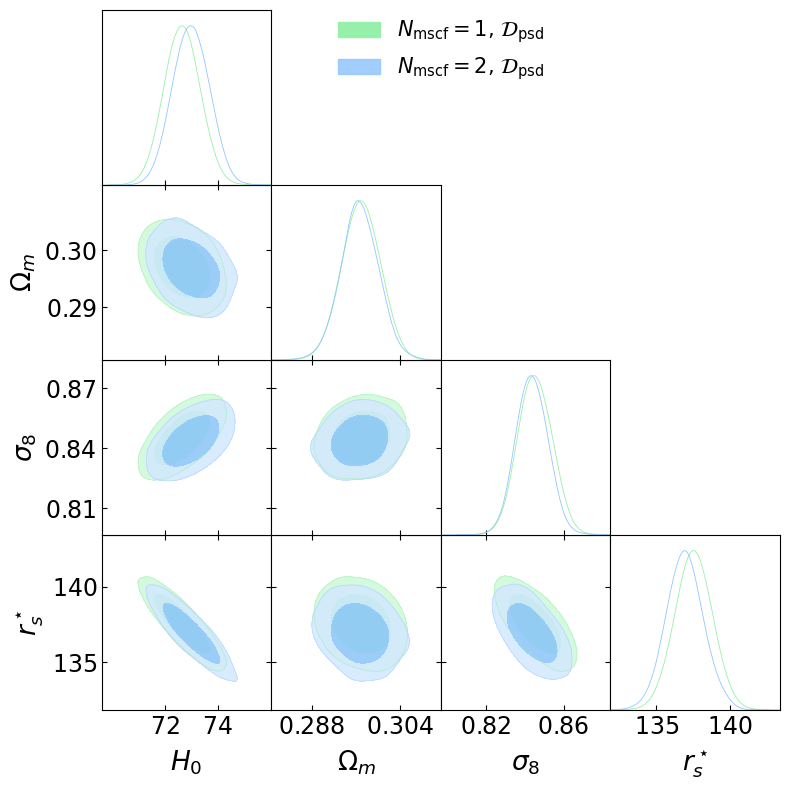

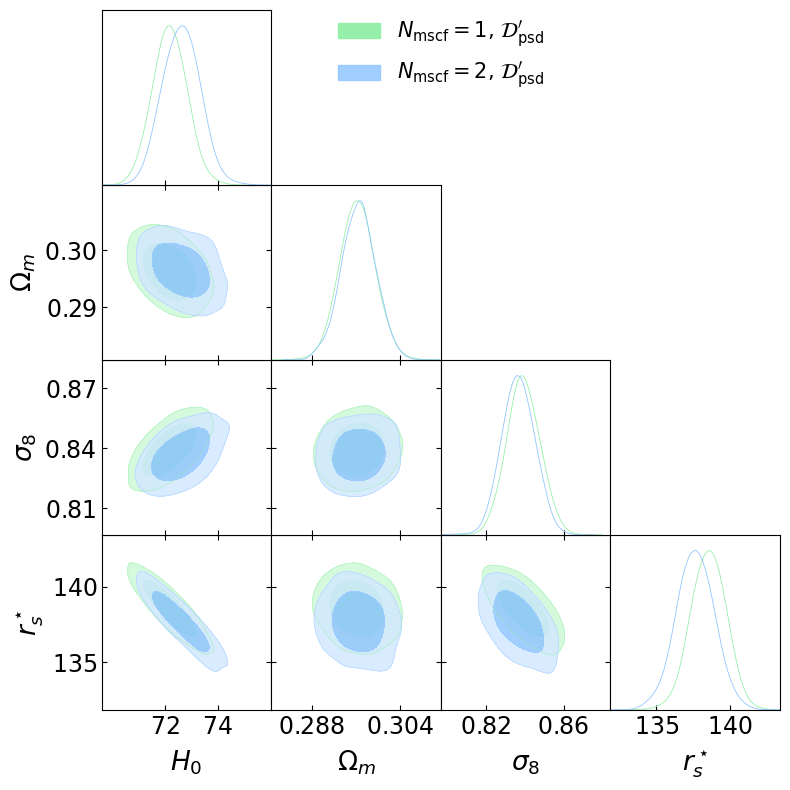

In [19]:
import plotting.plotting as pl
import matplotlib.pyplot as plt
import numpy as np

# Get all samples together to calculate global limits
param_names =['H0','Omega_m','sigma8','rs_star']

samp_1pd = load_samples(
     chain_1pd,
     param_names
 )

samp_1psd = load_samples(
     chain_1psd,
     param_names
 )
samp_1npd = load_samples(
     chain_1npd,
     param_names
 )
samp_1npsd = load_samples(
     chain_1npsd,
     param_names
 )
samp_2pd = load_samples(
     chain_2pd,
     param_names, burnin=0.2
 )

samp_2psd = load_samples(
     chain_2psd,
     param_names, burnin=0.2
 )

samp_2npd = load_samples(
     chain_2npd,
     param_names,burnin=0.2
 )
samp_2npsd = load_samples(
     chain_2npsd,
     param_names,burnin=0.2
 )
samp_3pd = load_samples(
     chain_3pd,
     param_names, burnin=0.2
 )

samp_3psd = load_samples(
     chain_3psd,
     param_names, burnin=0.2
 )

samp_3npd = load_samples(
     chain_3npd,
     param_names,burnin=0.2
 )
samp_3npsd = load_samples(
     chain_3npsd,
     param_names,burnin=0.2
 )

all_samples = [samp_1psd, samp_2psd, samp_1npsd, samp_2npsd, samp_3psd, samp_3npsd]

# Calculate min/max for each parameter across all samples
param_limits = {}
for param in param_names:
    all_vals = np.concatenate([samp[param] for samp in all_samples])
    min_val = all_vals.min()
    max_val = all_vals.max()
    # Add 5% padding
    padding = 0.05 * (max_val - min_val)
    param_limits[param] = (min_val - padding, max_val + padding)

print("Global limits:")
for param, (min_val, max_val) in param_limits.items():
    print(f"{param}: [{min_val:.3f}, {max_val:.3f}]")

# First triangle plot with fixed limits
g1 = pl.my_plotter()
fig1 = g1.triangle_plot(
    [samp_1psd, samp_2psd,samp_3psd],
    params=param_names,
    filled=True,
    legend_labels=[
        r"$N_\text{mscf}=1$, $\mathcal{D}_{\text{psd}}$",
        r"$N_\text{mscf}=2$, $\mathcal{D}_{\text{psd}}$",
        r"$N_\text{mscf}=3$, $\mathcal{D}_{\text{psd}}$",
    ],
    param_limits=param_limits  # Apply fixed limits
)

plt.show()
g1.export(str(PLOT_DIR / "1psd2psd.pdf"))

# Second triangle plot with EXACT SAME limits
g2 = pl.my_plotter()
fig2 = g2.triangle_plot(
    [samp_1npsd, samp_2npsd,samp_3npsd],
    params=param_names,
    filled=True,
    legend_labels=[
        r"$N_\text{mscf}=1$, $\mathcal{D}^\prime_{\text{psd}}$",
        r"$N_\text{mscf}=2$, $\mathcal{D}^\prime_{\text{psd}}$",
        r"$N_\text{mscf}=3$, $\mathcal{D}^\prime_{\text{psd}}$",
    ],
    param_limits=param_limits  # Same fixed limits
)

plt.show()
g2.export(str(PLOT_DIR / "1npsd2npsd.pdf"))

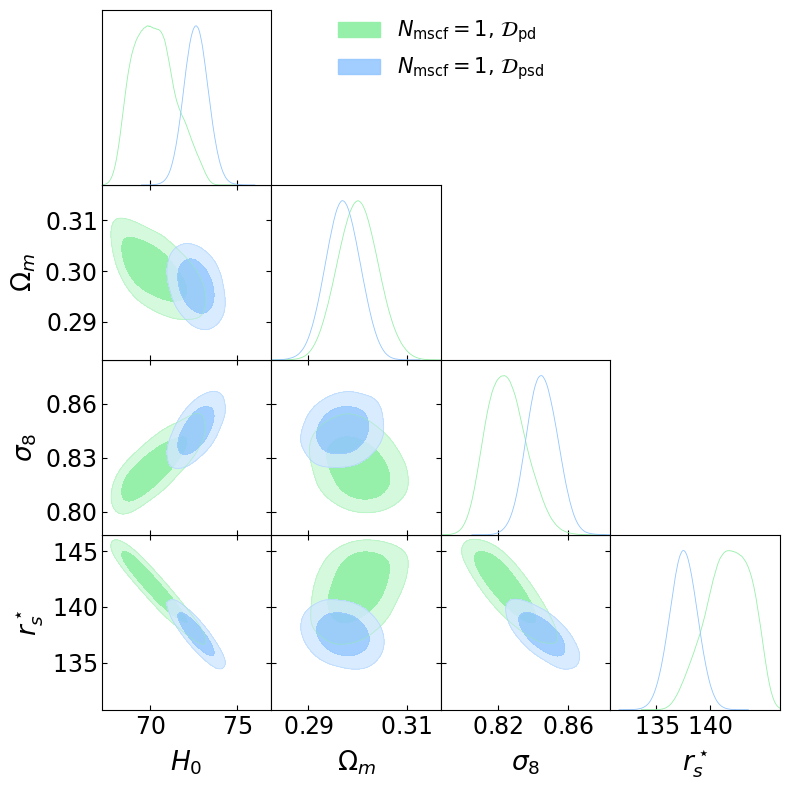

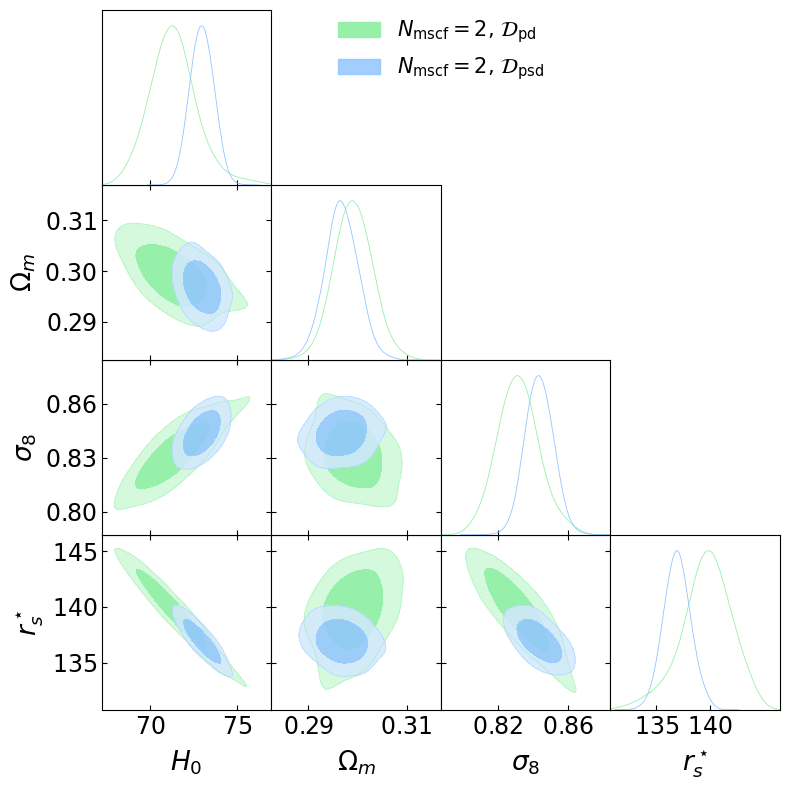

In [20]:
all_samples = [samp_1pd, samp_1psd, samp_2pd, samp_2psd]

# Calculate min/max for each parameter across all samples
param_limits = {}
for param in param_names:
    all_vals = np.concatenate([samp[param] for samp in all_samples])
    min_val = all_vals.min()
    max_val = all_vals.max()
    # Add 5% padding
    padding = 0.05 * (max_val - min_val)
    param_limits[param] = (min_val - padding, max_val + padding)

# First triangle plot with fixed limits
g1 = pl.my_plotter()
fig1 = g1.triangle_plot(
    [samp_1pd, samp_1psd],
    params=param_names,
    filled=True,
    legend_labels=[
        r"$N_\text{mscf}=1$, $\mathcal{D}_{\text{pd}}$",
        r"$N_\text{mscf}=1$, $\mathcal{D}_{\text{psd}}$",
    ],
    param_limits=param_limits  # Apply fixed limits
)

plt.show()
g1.export(str(PLOT_DIR / "1pd1psd.pdf"))

# Second triangle plot with EXACT SAME limits
g2 = pl.my_plotter()
fig2 = g2.triangle_plot(
    [samp_2pd, samp_2psd],
    params=param_names,
    filled=True,
    legend_labels=[
        r"$N_\text{mscf}=2$, $\mathcal{D}_{\text{pd}}$",
        r"$N_\text{mscf}=2$, $\mathcal{D}_{\text{psd}}$",
    ],
    param_limits=param_limits  # Same fixed limits
)

plt.show()
g2.export(str(PLOT_DIR / "2pd2psd.pdf"))

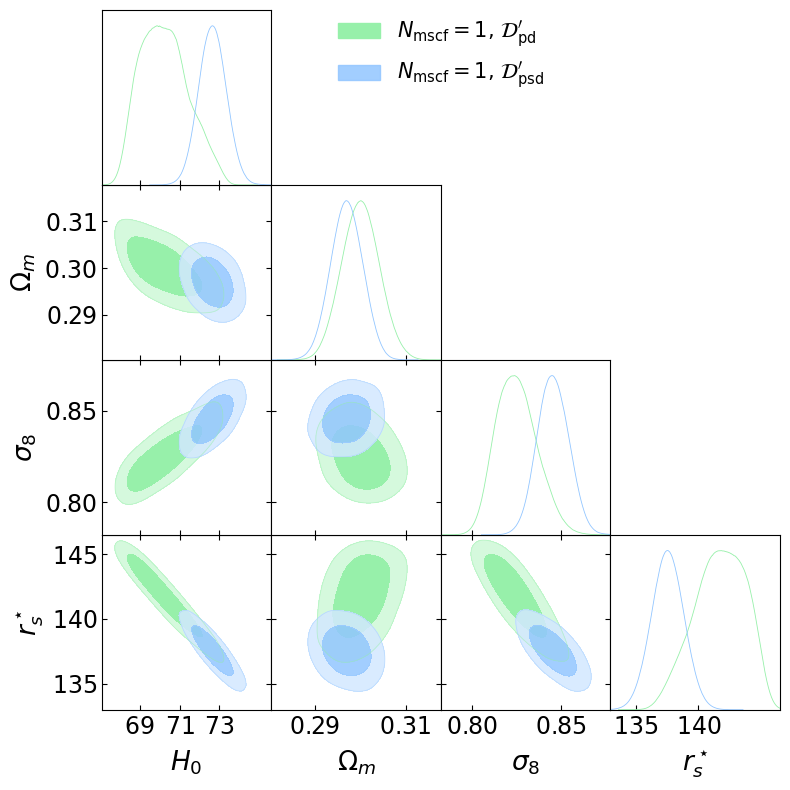

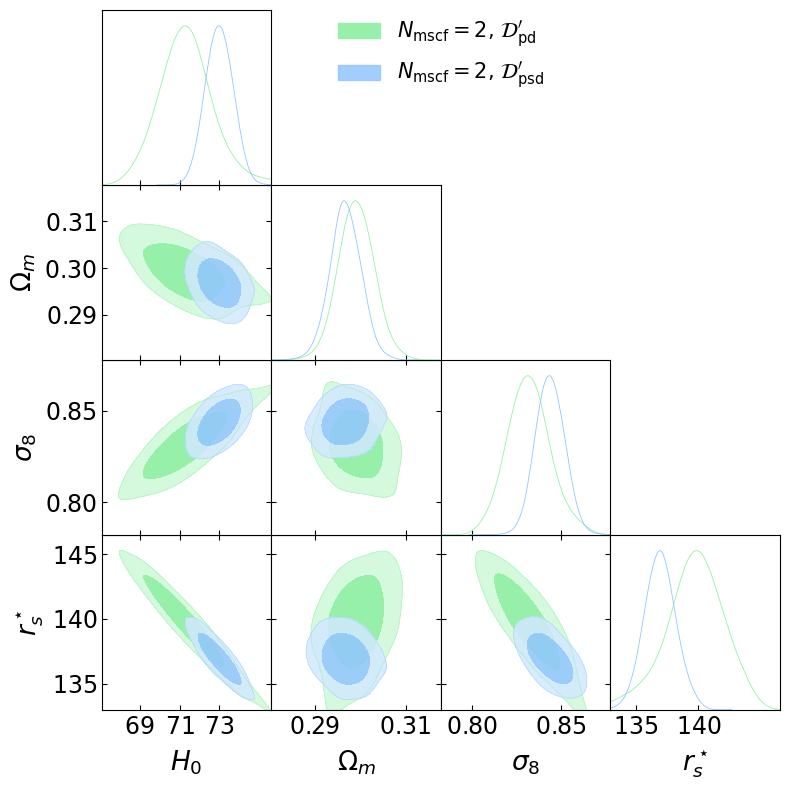

In [21]:
all_samples = [samp_1npd, samp_1npsd, samp_2npd, samp_2npsd]

# Calculate min/max for each parameter across all samples
param_limits = {}
for param in param_names:
    all_vals = np.concatenate([samp[param] for samp in all_samples])
    min_val = all_vals.min()
    max_val = all_vals.max()
    # Add 5% padding
    padding = 0.05 * (max_val - min_val)
    param_limits[param] = (min_val - padding, max_val + padding)

# First triangle plot with fixed limits
g1 = pl.my_plotter()
fig1 = g1.triangle_plot(
    [samp_1pd, samp_1psd],
    params=param_names,
    filled=True,
    legend_labels=[
        r"$N_\text{mscf}=1$, $\mathcal{D}^\prime_{\text{pd}}$",
        r"$N_\text{mscf}=1$, $\mathcal{D}^\prime_{\text{psd}}$",
    ],
    param_limits=param_limits  # Apply fixed limits
)

plt.show()
g1.export(str(PLOT_DIR / "1npd1npsd.pdf"))

# Second triangle plot with EXACT SAME limits
g2 = pl.my_plotter()
fig2 = g2.triangle_plot(
    [samp_2pd, samp_2psd],
    params=param_names,
    filled=True,
    legend_labels=[
        r"$N_\text{mscf}=2$, $\mathcal{D}^\prime_{\text{pd}}$",
        r"$N_\text{mscf}=2$, $\mathcal{D}^\prime_{\text{psd}}$",
    ],
    param_limits=param_limits  # Same fixed limits
)

plt.show()
g2.export(str(PLOT_DIR / "2npd2npsd.pdf"))